In [4]:
import datetime
from flickplay.mongo import get_mongo_db_obj
from flickplay.get_connections import get_alchemy_con, get_pymysql_con
from flickplay.utils import timer_func
import os
import pandas as pd
import numpy as np
import sys

wd='/Users/allen/Developer/clo/flickplay/mixpanel-events'
os.chdir(wd)
print(os.getcwd(), wd==os.getcwd())
db, conp, con = get_mongo_db_obj(), get_pymysql_con(), get_alchemy_con()

@timer_func
def get_nfts():
    print('Getting NFTs from experiences')
    nfts = db.experiences.find({'nft': True, 'certified': True})
    return pd.DataFrame.from_records(nfts)

@timer_func
def get_recordings():
    print('Getting recordings from recordings')
    return pd.DataFrame.from_records(db.recordings.find())

@timer_func
def get_certified_recordings(dr=None):
    if dr is None:
        dr = get_recordings()
    print('Construct DataFrame of Certified Recordings (dcr)')
    dcrids = []
    for idx, row in dr.iterrows():
        recording_has_certified_nft = False
        for e in row.experiences:
            if e in certified_nft_ids:
                dcrids.append(row._id)
                continue
    dcr = dr[dr._id.isin(dcrids)]
    dcr['month'] = dcr['created'].apply(lambda x: x.date().month)
    dcr['year'] = dcr.created.apply(lambda x: x.date().year)
    dcr['month'] = dcr.created.apply(lambda x: x.date().month)
    dcr['date'] = dcr.created.apply(lambda x: str(x.date().year)+'-'+str(x.date().month))
    return dcr

@timer_func
def get_users():
    print('Getting users from users')
    return pd.DataFrame(db.users.find())

@timer_func
def get_recording_aggregates(dcr=None):
    if dcr is None:
        dcr = get_certified_recordings()
        
    print('Doing Recordings Aggregates')
    recs = []
    for year in [2020,2021,2022,2023]:
        for month in [i+1 for i in range(12)]:
            if year == 2020:
                if month < 12:
                    continue
            if year == 2023:
                if month > 1:
                    continue
            date        = str(year)+'-'+str(month)
            nrecordings = len(dcr[(dcr.year==year) & (dcr.month==month)])
            recordings  = list(set(dcr[(dcr.year==year) & (dcr.month==month)]._id))
            nusers      = len(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
            users       = list(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
            rec         = {
                            'date': date,
                            'year': year,
                            'month': month,
                            'recordings': recordings,
                            'n_recordings': nrecordings,
                            'n_users': nusers,
                            'users': users }
            recs.append(rec)
    aggregates = pd.DataFrame.from_records(recs)
    return aggregates

@timer_func
def get_process_recordings(dcr=None, dr=None):
    if dr is None:
        dr = get_recordings()
    if dcr is None:
        dcr=get_certified_recordings(dr=dr)
    recordings_with_certified_nft = dcr
    print('Processing Recordings')
    dr['hasCertifiedNFT'] = [ True if row._id in set(recordings_with_certified_nft._id.values) else False for idx, row in dr.iterrows() ]
    return dr

@timer_func
def get_web3_cohort():
    query = """select distinct($user_id) from fpa.events where event='profile_wallet__connect_suc'"""
    return pd.read_sql(query, con)


@timer_func
def get_process_users(nfts=None,
                      users=None):
    if nfts is None:
        nfts = get_nfts()
    if users is None:
        print('Fetching Users')
        users = get_users()
    print('Processing User hasCertifiedNFT')
    nftOwners = set(nfts.nftOwner)
    users['ownsCertifiedNFT'] = users._id.apply(lambda x: x in nftOwners)
    web3 = set(get_web3_cohort()['$user_id'])
    users['web3Cohort'] = users._id.apply(lambda x: 1 if x in web3 else 0)
    return users

def process_reg_type(user):
    if user.anonymous:
        return 'anonymous'
    elif user.createdThroughConnectWallet:
        return 'wallet connect'
    elif not np.isnan(user.appleId):
        return 'apple'
    else:
        return 'regular'

def get_registration_filter(kind='apple'):
    if kind not in ('apple', 'walletConnect', 'regular', 'anonymous'):
        raise ValueError(f"kind must be one of 'apple', 'walletConnect', 'regular', 'anonymous'")
    if kind == 'apple':
        return {'appleId': {'$ne': None}}
    elif kind == 'walletConnect':
        return {'createdThroughConnectWallet': True}
    elif kind == 'anonymous':
        return {'anonymous': True}
    else:
        return  {'anonymous': False, 'createdThroughConnectWallet': False, 'appleId': None}
    
@timer_func
def get_users_by_reg_type(kind='apple'):
    reg_filter = get_registration_filter(kind=kind)
    return pd.DataFrame.from_records(db.users.find(reg_filter))


@timer_func
def map_appleSignup(u):
    uids = set(userids_by_reg_type['apple'])
    u['appleSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_walletSignup(u):
    uids = set(userids_by_reg_type['walletConnect'])
    u['walletSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_regularSignup(u):
    uids = set(userids_by_reg_type['regular'])
    u['regularSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_strUserId(u):
    u['user_id'] = u._id.apply(lambda x: str(x))
    return u

@timer_func
def map_sum_signups(u):
    cols = ['appleSignup','walletSignup','regularSignup','anonymous']
    u['signup_markers'] = u[cols].apply(lambda x: sum(x), axis=1)
    return u

@timer_func
def map_unclassifiedSignup(u):
    unclassified_registered = u[(u.anonymous==False) & (u.appleSignup==False) & (u.walletSignup==False) & (u.regularSignup==False)]
    uncl_reg = set(unclassified_registered.user_id.values)
    u['unclassifiedSignup'] = u.user_id.apply(lambda x: int(x in uncl_reg))
    return u



/Users/allen/Developer/clo/flickplay/mixpanel-events True


In [5]:
# import os
# os.getcwd()

In [6]:
nfts = get_nfts()
# users_with_certified_nft = set(nfts.ownerWalletAddress)
u = get_process_users(nfts=nfts)


Getting NFTs from experiences
Function 'get_nfts' executed in 120.7018s
Fetching Users
Getting users from users
Function 'get_users' executed in 29.5494s
Processing User hasCertifiedNFT
Function 'get_web3_cohort' executed in 10.6794s
Function 'get_process_users' executed in 40.3549s


# Outcome of user after wallet connect event
* describe retention, with/without verified NFT
* retention v.s. # of verified NFTs



# add web3 cohort to users table
* 'wallet_connect_first_datetime'
* web3 cohort w/wo verified NFT
* what are the users doing, who don't have an NFT?
              \ 
             who stay?
             
# most common event among users who stay


In [7]:
# u = get_process_users(users=users,
#                       nfts=nfts)

In [9]:
apple = get_users_by_reg_type('apple')
regular = get_users_by_reg_type('regular')
walletConnect = get_users_by_reg_type('walletConnect')
anonymous = get_users_by_reg_type('anonymous')

users_by_reg_type = {
    'all': u,
    'apple': apple,
    'regular': regular,
    'walletConnect': walletConnect,
    'anonymous': anonymous
}

[ print(k, len(users_by_reg_type[k])) for k in users_by_reg_type.keys() ]

userids_by_reg_type = { k:df._id.values for k, df in users_by_reg_type.items() }

Function 'get_users_by_reg_type' executed in 1.5859s
Function 'get_users_by_reg_type' executed in 1.4955s
Function 'get_users_by_reg_type' executed in 0.4665s
Function 'get_users_by_reg_type' executed in 20.2980s
all 65069
apple 2768
regular 2804
walletConnect 592
anonymous 49903


In [2]:

@timer_func
def map_appleSignup(u):
    uids = set(userids_by_reg_type['apple'])
    u['appleSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_walletSignup(u):
    uids = set(userids_by_reg_type['walletConnect'])
    u['walletSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_regularSignup(u):
    uids = set(userids_by_reg_type['regular'])
    u['regularSignup'] = u._id.apply(lambda x: int(x in uids))
    return u

@timer_func
def map_strUserId(u):
    u['user_id'] = u._id.apply(lambda x: str(x))
    return u

@timer_func
def map_sum_signups(u):
    cols = ['appleSignup','walletSignup','regularSignup','anonymous']
    u['signup_markers'] = u[cols].apply(lambda x: sum(x), axis=1)
    return u

@timer_func
def map_unclassifiedSignup(u):
    unclassified_registered = u[(u.anonymous==False) & (u.appleSignup==False) & (u.walletSignup==False) & (u.regularSignup==False)]
    uncl_reg = set(unclassified_registered.user_id.values)
    u['unclassifiedSignup'] = u.user_id.apply(lambda x: int(x in uncl_reg))
    return u



In [ ]:

# u = map_appleSignup(u)
# u = map_walletSignup(u)
# u = map_regularSignup(u)
# u = map_strUserId(u)

In [3]:
@timer_func
def map_sum_signups(u):
    cols = ['appleSignup','walletSignup','regularSignup','anonymous']
    u['signup_markers'] = u[cols].apply(lambda x: sum(x), axis=1)
    return u

@timer_func
def map_unclassifiedSignup(u):
    unclassified_registered = u[(u.anonymous==False) & (u.appleSignup==False) & (u.walletSignup==False) & (u.regularSignup==False)]
    uncl_reg = set(unclassified_registered.user_id.values)
    u['unclassifiedSignup'] = u.user_id.apply(lambda x: int(x in uncl_reg))
    return u



In [ ]:
u = map_appleSignup(u)
u = map_walletSignup(u)
u = map_regularSignup(u)
u = map_strUserId(u)

u = map_sum_signups(u)
u = map_unclassifiedSignup(u)

In [21]:
users = u.copy()

u = u[['_id','user_id', 'username',
       'appleSignup', 'walletSignup', 'regularSignup', 'anonymous', 'unclassifiedSignup',
       'signup_markers',
       'ownsCertifiedNFT',
       'web3Cohort',
       'created', 'updated', 'lastUsed',
       'device', 'ios', 
       #'profileImage', 'googleId', 'facebookId', 'appleId', 'email',
       'name', 'age', 'gender', 'sex',
       #'bio', 
       'countryCode', 'phone', 
       #'phoneHash',
       'role', 'isUser', 'isAdmin', 
       #'loginCount', 'deleted', 
       # 'active', 
       #'verified', 
       'followingCount', 'followersCount', 'likesCount',
       'pointsCollected', 'flicksTotal', 
       'lastHomeFeedDate', 'lastNotificationDate', 
       #'pointsLastFlick',
       #'lang', 'presaleCode', 'isValidPresaleCode',
       #'blockedUsers', 
       #'salt', 'hashedPassword', 
       #'profilePoints', 'pushToken', 
       'allTimePoints','viewsCount', 
       #'overrideViewsCount', 
       'wasAnonymous', 'allowMap', 'allowVideoMap', 'allowPinVideo',
       'collectionsCount', 'collectionsSavedCount', 
       #'tipsBalance', 'allTips',
       'cameraPermission', 'locationPermission', 'notificationPermission',
       'isMapCreator', 'allowAutopopulation', 'isCertified', 
       #'pushTokens',
       'allTimeLikes', 
       # 'isMapCreatorDelete', 
       #'pushCounterFollowing', 'pushCounterWallet', 'spotCount', 'isBlocked', 'lastSyncDate',
       'createdThroughConnectWallet', 
       #'isExperienceCreator', 'nftCreator', 'flicks', 'yellowButtonCollected', 'walls', 'chameleonButton', 
       # 'flicksCollected', 
       #'pushCounterLikes', 'avatar', 'profileCover', 'keychainToken', 'lastSpotRecordingId', 'mapThumbnail', 'lastTipsDate',
       #'deviceId', '__v', 'profileCoverV2', 'profileCoverVideoId',
       #'profileCoverOffsetMultiplier', 'idfa', 'idfv'
      ]]

u1 = u.infer_objects().copy()

def map_bool_to_int(colname, userdf):
    return userdf[colname].apply(lambda x: int(x) if type(x)==bool else x)

def kill_nan(colname, userdf):
    return userdf[colname].apply(lambda x: None if np.isnan(x) else x)

for col in u1.columns:
    print(col)
    try:
        u1[col] = map_bool_to_int(col, u1)
        u1[col] = kill_nan(col, u1)
    except Exception as e:
        print(e)
    
# u = u1.copy()

# u.apply(kill
# # u.infer_objects()

_id
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
user_id
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
username
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
appleSignup
walletSignup
regularSignup
anonymous
unclassifiedSignup
signup_markers
ownsCertifiedNFT
web3Cohort
created
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
updated
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
lastUsed
ufunc 'isnan' not supported for the input types, and the inputs could not

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,unclassifiedSignup,signup_markers,ownsCertifiedNFT,...,collectionsCount,collectionsSavedCount,cameraPermission,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,createdThroughConnectWallet
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,0,0,1,0.0,0,1.0,0,...,1,0,authorized,authorizedWhenInUse,denied,0.0,0.0,0.0,440.0,0.0
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,1,0,0,0.0,0,1.0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,1,0,0,NaN,0,NaN,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,0,0,0,0.0,1,0.0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,1,0,0,0.0,0,1.0,0,...,0,0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65064,63d2686ad88e330c0596d441,63d2686ad88e330c0596d441,anonymous-5348724,0,0,0,1.0,0,1.0,0,...,0,0,notDetermined,denied,notDetermined,0.0,0.0,0.0,0.0,0.0
65065,63d26b6814dfce5c1f755ad4,63d26b6814dfce5c1f755ad4,anonymous-45911075,0,0,0,1.0,0,1.0,0,...,0,0,notDetermined,notDetermined,notDetermined,0.0,0.0,0.0,0.0,0.0
65066,63d27333d252aed6d19086ef,63d27333d252aed6d19086ef,anonymous-16502305,0,0,0,1.0,0,1.0,0,...,0,0,authorized,notDetermined,notDetermined,0.0,0.0,0.0,0.0,0.0
65067,63d2b389d88e330bc898abcb,63d2b389d88e330bc898abcb,anonymous-34938289,0,0,0,1.0,0,1.0,0,...,0,0,notDetermined,notDetermined,notDetermined,0.0,0.0,0.0,1.0,0.0


In [35]:
# u.anonymous.apply(knan)

In [ ]:
# con = get_alchemy_con()

# u.infer_objects()\
#  .to_sql('users',
#           con,
#           if_exists='replace',
#           index=False)

In [17]:
u

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,unclassifiedSignup,signup_markers,ownsCertifiedNFT,...,collectionsCount,collectionsSavedCount,cameraPermission,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,createdThroughConnectWallet
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,0,0,1,False,0,1.0,False,...,1,0,authorized,authorizedWhenInUse,denied,False,False,False,440.0,False
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,1,0,0,False,0,1.0,False,...,0,0,NaN,NaN,NaN,None,None,None,4.0,None
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,1,0,0,None,0,NaN,False,...,0,0,NaN,NaN,NaN,None,None,None,NaN,None
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,0,0,0,False,1,0.0,False,...,0,0,NaN,NaN,NaN,None,None,None,20.0,None
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,1,0,0,False,0,1.0,False,...,0,0,NaN,NaN,NaN,False,None,None,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65064,63d2686ad88e330c0596d441,63d2686ad88e330c0596d441,anonymous-5348724,0,0,0,True,0,1.0,False,...,0,0,notDetermined,denied,notDetermined,False,False,False,0.0,False
65065,63d26b6814dfce5c1f755ad4,63d26b6814dfce5c1f755ad4,anonymous-45911075,0,0,0,True,0,1.0,False,...,0,0,notDetermined,notDetermined,notDetermined,False,False,False,0.0,False
65066,63d27333d252aed6d19086ef,63d27333d252aed6d19086ef,anonymous-16502305,0,0,0,True,0,1.0,False,...,0,0,authorized,notDetermined,notDetermined,False,False,False,0.0,False
65067,63d2b389d88e330bc898abcb,63d2b389d88e330bc898abcb,anonymous-34938289,0,0,0,True,0,1.0,False,...,0,0,notDetermined,notDetermined,notDetermined,False,False,False,1.0,False


In [ ]:
query = """
SELECT 
	device, 
	count(*) cnt
FROM 
	(select * from fpa.users where lastUsed>='2022-1-1') x
GROUP BY device
HAVING device is not null
ORDER BY cnt DESC;
"""

devices = pd.read_sql(query, con)

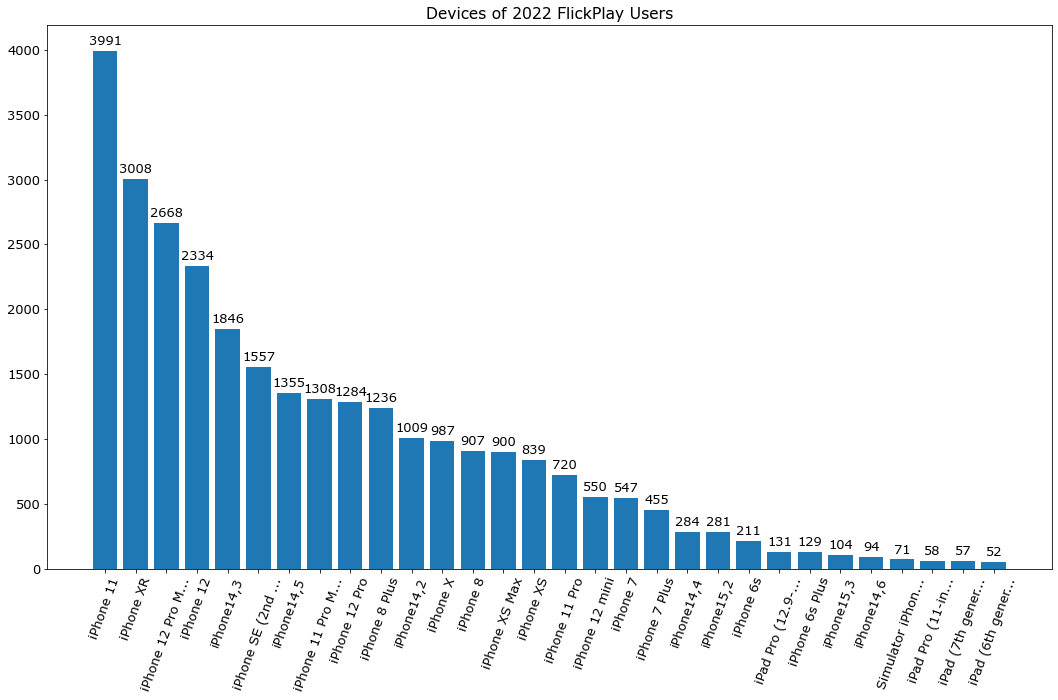

In [321]:
from flickplay.utils import make_big
import matplotlib.pyplot as plt

N_DEVICES = 30
XLABEL_STR_LENGTH = 15
FONT_SIZE = 13

xsl = XLABEL_STR_LENGTH
nd = N_DEVICES

labels = [ _[:xsl]+'...' if len(_)>xsl else _ for _ in devices['device'].values[:nd] ]
y = devices['cnt'].values[:nd]

fix, ax = make_big(f=FONT_SIZE)
a = ax.bar(labels, y)

plt.title('Devices of 2022 FlickPlay Users')
plt.xticks(rotation=70)
ax.bar_label(a, padding=3)
plt.savefig('/Users/allen/Desktop/devices.jpg',format='jpg')

In [378]:
pd.set_option('display.max_rows',None)
print(devices)

                                   device   cnt
0                               iPhone 11  3991
1                               iPhone XR  3008
2                       iPhone 12 Pro Max  2668
3                               iPhone 12  2334
4                              iPhone14,3  1846
5              iPhone SE (2nd generation)  1557
6                              iPhone14,5  1355
7                       iPhone 11 Pro Max  1308
8                           iPhone 12 Pro  1284
9                           iPhone 8 Plus  1236
10                             iPhone14,2  1009
11                               iPhone X   987
12                               iPhone 8   907
13                          iPhone XS Max   900
14                              iPhone XS   839
15                          iPhone 11 Pro   720
16                         iPhone 12 mini   550
17                               iPhone 7   547
18                          iPhone 7 Plus   455
19                             iPhone14,

In [1]:
from flickplay.utils import make_big
import matplotlib.pyplot as plt

FONT_SIZE = 13

query="""
SELECT 
	month(created) as month_,
	year(created) as year_,
	sum(appleSignup) apple,
	sum(walletSignup) wallet,
	sum(regularSignup) regular,
	sum(anonymous) anon,
	sum(unclassifiedSignup) unclassified
FROM
	fpa.users
GROUP BY 
	year_, month_
ORDER BY
	year_, month_ ASC
"""

signup_totals = pd.read_sql(query, con)
signup_totals['labels'] = [ str(signup_totals['month_'].iloc[idx])+'-'+\
                           str(signup_totals['year_'].iloc[idx]) for idx in range(len(signup_totals)) ]

labels = signup_totals['labels'].values
apple = signup_totals.apple
wallet = signup_totals.wallet
regular = signup_totals.regular
anon = signup_totals.anon
unclassed = signup_totals.unclassified

pos = np.arange(len(labels))
colors = iter([plt.cm.tab20(i) for i in range(20)])

fix, ax = make_big(f=FONT_SIZE, w=46, h=14)

pos = np.arange(len(labels))
width=0.18

a = ax.bar(pos - 2*width, apple,    width, label='apple', color=[next(colors)])
w = ax.bar(pos - 1*width, wallet,   width, label='walletConnect', color=[next(colors)])
r = ax.bar(pos + 0*width, regular,  width, label='regular', color=[next(colors)])
o = ax.bar(pos + 1*width, anon,     width, label='anon', color=[next(colors)])
u = ax.bar(pos + 2*width, unclassed,width, label='unclassified', color=[next(colors)])

ax.set_xticks(pos)
ax.set_xticklabels(labels)
plt.xticks(rotation=70)

#plt.yscale('log')
plt.title('New Users By Signup Method')
plt.legend(loc=2)

plt.savefig('/Users/allen/Desktop/signups.jpg', format='jpg')
signup_totals[signup_totals.columns[:-1]]

plt.show()

NameError: name 'pd' is not defined

In [375]:
signup_totals['month'] = signup_totals['labels']

print(signup_totals[['month','apple','wallet','regular','anon','unclassified']])

      month  apple  wallet  regular    anon  unclassified
0   10-2019    0.0     0.0      0.0     0.0           1.0
1   11-2019    0.0     0.0      0.0     0.0           2.0
2   12-2019    3.0     0.0      0.0     0.0           0.0
3    2-2020    1.0     0.0      0.0     0.0           0.0
4    3-2020    8.0     0.0      1.0     0.0           0.0
5    4-2020    1.0     0.0      2.0     0.0           2.0
6    5-2020   11.0     0.0     11.0     0.0           8.0
7    6-2020   13.0     0.0      4.0     0.0          10.0
8    7-2020  124.0     0.0     18.0     0.0         120.0
9    8-2020   78.0     0.0      7.0     0.0          75.0
10   9-2020   28.0     0.0      3.0     0.0          34.0
11  10-2020   29.0     0.0      7.0     0.0          33.0
12  11-2020   37.0     0.0      7.0     0.0          37.0
13  12-2020   46.0     0.0      3.0     0.0          43.0
14   1-2021   23.0     0.0      6.0    80.0          28.0
15   2-2021  122.0     0.0      9.0  1452.0         140.0
16   3-2021   

In [374]:
signup_totals.columns

Index(['month_', 'year_', 'apple', 'wallet', 'regular', 'anon', 'unclassified',
       'labels', 'month'],
      dtype='object')

(array([211., 163., 151.,  97.,  85.,  54.,  46.,  40.,  26.,  28.,  23.,
         17.,  12.,   7.,  11.,  11.,   6.,   1.,   1.,   2.,   3.,   2.,
          0.,   1.,   2.]),
 array([1.91827775e-03, 1.07335915e+00, 2.14480001e+00, 3.21624088e+00,
        4.28768175e+00, 5.35912262e+00, 6.43056348e+00, 7.50200435e+00,
        8.57344522e+00, 9.64488609e+00, 1.07163270e+01, 1.17877678e+01,
        1.28592087e+01, 1.39306496e+01, 1.50020904e+01, 1.60735313e+01,
        1.71449722e+01, 1.82164130e+01, 1.92878539e+01, 2.03592948e+01,
        2.14307356e+01, 2.25021765e+01, 2.35736174e+01, 2.46450582e+01,
        2.57164991e+01, 2.67879400e+01]),
 <BarContainer object of 25 artists>)

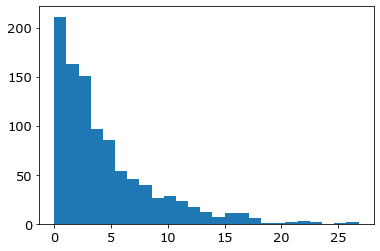

In [337]:

dist = [ -10*np.log10(np.random.rand()) for _ in range(1000) ]
plt.hist(dist, bins=25)

In [367]:
np.std([ -10*np.log10(np.random.rand()) for _ in range(1000000) ])

4.349205428294837

In [8]:
from flickplay.users import get_process_users

In [ ]:
u = get_process_users()

In [34]:
class SQLFactory(object):
   
    @classmethod
    def get_pymysql_con(cls):
        return get_pymysql_con()
    @classmethod
    def get_alchemy_con(cls):
        return get_alchemy_con()
    
    DEFAULT_QUERY = """
    SHOW TABLES FROM fpa.events;
    """
    
    def __init__(self):
        self.query = self.DEFAULT_QUERY
        self.conp = self.get_pymysql_con()
        self.con = self.get_alchemy_con()
        
    def set_query(self, new_query=None):
        if new_query is None:
            self.query = self.DEFAULT_QUERY
        else:
            self.query = new_query
            
    def get(self):
        return pd.read_sql(self.query, self.conp)
    
        
        
class Devices(SQLFactory):
    
    DEFAULT_QUERY = """
    SELECT 
        device, 
        count(*) cnt
    FROM 
        (select * from fpa.users where lastUsed>='2022-1-1') x
    GROUP BY device
    HAVING device is not null
    ORDER BY cnt DESC;"""

    def __init__(self):
        super().__init__()
        self.set_query()

    
    
class Users(SQLFactory):
    
    DEFAULT_QUERY = """
    SELECT *
    FROM fpa.users;
    """
    
    def __init__(self):
        super().__init__()
        self.set_query()
    

In [37]:
d=Devices()
d.query

u=Users()
u.get()

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,unclassifiedSignup,signup_markers,ownsCertifiedNFT,...,collectionsCount,collectionsSavedCount,cameraPermission,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,createdThroughConnectWallet
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,0,0,1,0.0,0,1.0,0,...,1,0,authorized,authorizedWhenInUse,denied,0.0,0.0,0.0,440.0,0.0
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,1,0,0,0.0,0,1.0,0,...,0,0,None,None,None,NaN,NaN,NaN,4.0,NaN
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,1,0,0,NaN,0,NaN,0,...,0,0,None,None,None,NaN,NaN,NaN,NaN,NaN
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,0,0,0,0.0,1,0.0,0,...,0,0,None,None,None,NaN,NaN,NaN,20.0,NaN
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,1,0,0,0.0,0,1.0,0,...,0,0,None,None,None,0.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64844,63d036974ba7a9170c0a2bde,63d036974ba7a9170c0a2bde,anonymous-6177321,0,0,0,1.0,0,1.0,0,...,0,0,notDetermined,denied,notDetermined,0.0,0.0,0.0,0.0,0.0
64845,63d0373d0c6642503400be79,63d0373d0c6642503400be79,anonymous-57901102,0,0,0,1.0,0,1.0,0,...,0,0,None,None,None,0.0,0.0,0.0,0.0,0.0
64846,63d037d00c6642655c00beea,63d037d00c6642655c00beea,anonymous-79003159,0,0,0,1.0,0,1.0,0,...,0,0,notDetermined,denied,notDetermined,0.0,0.0,0.0,0.0,0.0
64847,63d038b53e3aa5680e1d5ef0,63d038b53e3aa5680e1d5ef0,gjax,0,0,1,0.0,0,1.0,0,...,0,0,notDetermined,notDetermined,notDetermined,0.0,0.0,0.0,0.0,0.0


In [4]:
from flickplay.query import Devices, Users, Registrations

d = Devices()
devices = d.get()

r = Registrations()
registrations = r.get()

u = Users()
users = u.get()



Function 'get' executed in 0.0826s


,device,cnt
0,iPhone 11,3991
1,iPhone XR,3008
2,iPhone 12 Pro Max,2668
3,iPhone 12,2334
4,"iPhone14,3",1846
...,...,...
70,Simulator iPhone X,1
71,"iPad13,9",1
72,"iPad13,7",1
73,"iPad14,5",1


In [6]:
Registrations().get()

Function 'get' executed in 0.0982s


,month_,year_,apple,wallet,regular,anon,unclassified
0,10,2019,0.0,0.0,0.0,0.0,1.0
1,11,2019,0.0,0.0,0.0,0.0,2.0
2,12,2019,3.0,0.0,0.0,0.0,0.0
3,2,2020,1.0,0.0,0.0,0.0,0.0
4,3,2020,8.0,0.0,1.0,0.0,0.0
5,4,2020,1.0,0.0,2.0,0.0,2.0
6,5,2020,11.0,0.0,11.0,0.0,8.0
7,6,2020,13.0,0.0,4.0,0.0,10.0
8,7,2020,124.0,0.0,18.0,0.0,120.0
9,8,2020,78.0,0.0,7.0,0.0,75.0


In [ ]:
Users.get()